In [1]:
environment = "local"
if environment == "drive":
    dirname = 'drive/MyDrive/europarl/'
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -r requirements
else:
    dirname = 'europarl/'

In [2]:
import torch
import torch.nn as nn
import numpy as np
import clip
from sentence_transformers import SentenceTransformer

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
#Our sentences we like to encode

train_path = 'train_sentences.txt'
test_path = 'test_sentences.txt'
valid_path = 'valid_sentences.txt'
train_filename = dirname + '/' + train_path
test_filename = dirname + '/' + test_path
valid_filename = dirname + '/' + valid_path

In [5]:
train_sentences = []
with open(train_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        train_sentences.append(line)
N = len(train_sentences)
print("Number of sentences : {}".format(N))

Number of sentences : 500


In [6]:
for line in train_sentences:
    N = len(line.split())
    if N > 75:
      print(N)
      print(line)

In [7]:
import re
regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
for r in regex:
  train_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), train_sentences))

In [8]:
text = clip.tokenize(train_sentences).to(device)

In [9]:
with torch.no_grad():
    clip_embeddings = clip_model.encode_text(text)

In [10]:
with torch.no_grad():  
    sbert_embeddings = torch.from_numpy(sbert_model.encode(train_sentences))

In [11]:
#Print the embeddings
for sentence, clip_embedding, sbert_embedding in zip(train_sentences[:1], clip_embeddings[:1], sbert_embeddings[:1]):
    print("Sentence:", sentence)
    print("Clip Embedding: ", clip_embedding.size())
    print("Sbert Embedding: ", sbert_embedding.size())
    print("-"*10)

Sentence: You have requested a debate on this subject in the course of the next few days during this part session 
Clip Embedding:  torch.Size([512])
Sbert Embedding:  torch.Size([384])
----------


In [12]:
class SCLIPNN(nn.Module):
    def __init__(self):
        super(SCLIPNN, self).__init__()
        self.linear1 = nn.Linear(384,100)
        self.linear2 = nn.Linear(100,512)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        logits = self.linear2(x)
        return logits

In [13]:
model = SCLIPNN().to(device)
print(model)

SCLIPNN(
  (linear1): Linear(in_features=384, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=512, bias=True)
  (relu): ReLU()
)


In [14]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
losses = []
for epoch in range(150):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for i, data in enumerate(zip(sbert_embeddings, clip_embeddings)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #print("Outputs and Labels size: {} - {}".format(outputs.size(),labels.size()))
        
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    losses.append(epoch_loss)
    
    if epoch + 1 % 10 == 0:
      print("Epoch {}. Loss: {}".format(epoch+1,epoch_loss))
print('Finished Training')

Epoch 1. Loss: 132.24264845252037
Epoch 11. Loss: 25.176183503121138
Epoch 21. Loss: 22.972768472507596
Epoch 31. Loss: 22.026932649314404
Epoch 41. Loss: 21.406077610328794
Epoch 51. Loss: 20.941521272063255
Epoch 61. Loss: 20.56183104403317
Epoch 71. Loss: 20.231640107929707
Epoch 81. Loss: 19.930323293432593
Epoch 91. Loss: 19.64750811085105
Epoch 101. Loss: 19.378390211611986
Epoch 111. Loss: 19.121641194447875
Epoch 121. Loss: 18.877272825688124
Epoch 131. Loss: 18.646882213652134
Epoch 141. Loss: 18.431284856051207
Finished Training


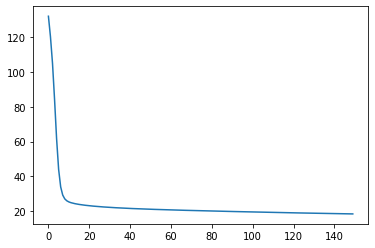

In [16]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [18]:
test_sentences = []
with open(test_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        test_sentences.append(line)
N = len(test_sentences)
print("Number of sentences : {}".format(N))

Number of sentences : 125


In [19]:
text = clip.tokenize(test_sentences).to(device)
with torch.no_grad():
    test_clip_embeddings = clip_model.encode_text(text)

In [20]:
with torch.no_grad():
    test_sbert_embeddings = torch.from_numpy(sbert_model.encode(test_sentences))
    prediction_embeddings = model(test_sbert_embeddings)

In [21]:
cosines = []
for clipem, predem in zip(test_clip_embeddings, prediction_embeddings):
  cos = nn.CosineSimilarity(dim=0, eps=1e-6)
  cosine = cos(clipem, predem)
  cosines.append(cosine.item())
np_cosines = np.array(cosines)

terms = []
for i, c in enumerate(cosines):
  if np_cosines.size == 0:
    break
  best_index = np.argmax(np_cosines)
  coeff = np_cosines[best_index]/(i+1)
  terms.append(coeff)
  np_cosines = np.delete(np_cosines, best_index)
mean_reciprocal_rank = sum(terms) / len(terms)
print("Mean reciprocal mean: {}".format(mean_reciprocal_rank))

Mean reciprocal mean: 0.04112948697314904


In [22]:
euclidean = torch.cdist(test_clip_embeddings, prediction_embeddings)
avg_euclidean = torch.mean(euclidean)
print("Average Euclidean: {}".format(avg_euclidean))

Average Euclidean: 5.139171123504639


In [23]:
print(test_clip_embeddings[0,:7])
print('-'*20)
print(prediction_embeddings[0,:7])

tensor([-0.2260, -0.3205, -0.1991, -0.3055,  0.3207,  0.2823,  0.2040])
--------------------
tensor([ 0.0690, -0.0512, -0.0391, -0.0413,  0.0494, -0.0264,  0.1031])


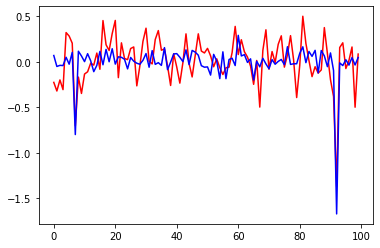

In [24]:
plt.plot(test_clip_embeddings[0,:100],c='r')
plt.plot(prediction_embeddings[0,:100],c='b')
plt.show()